In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import mutual_info_regression

## 0. Colab enter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

100% 199k/199k [00:00<00:00, 531kB/s]
100% 199k/199k [00:00<00:00, 531kB/s]


In [8]:
!unzip -q 'house-prices-advanced-regression-techniques.zip'

## 1. Inputs

In [9]:
train = pd.read_csv('train.csv').drop(['Id'], axis=1)
test = pd.read_csv('test.csv').drop(['Id'], axis=1)

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
#where are NaNs?

nanVals = [value for value in train.isnull().sum() if value != 0]
nanKeys = train.keys()[train.isnull().sum() != 0]
nans = pd.Series(data=nanVals, index=nanKeys)
print(nans)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [11]:
col_drop = nans[nans > 600]
print(col_drop)

Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64


In [ ]:
#dataset data types

print(train.dtypes.unique())

[dtype('int64') dtype('O') dtype('float64')]


 Small corr features:
  Street, LandContour, LandSlope, KitchenAbvGr

## 2.1 Visual Data Cleansing:

In [12]:
def data_plot_conversion(data: pd.DataFrame) -> pd.DataFrame:
    data = data.drop(col_drop.keys(), axis=1).query('SalePrice < 600_000')

    data = data.query('LotFrontage < 200 & LotArea < 70_000')
    data = data.query('BsmtFinSF1 < 2000 & BsmtFinSF2 < 1400 & TotalBsmtSF < 3000')

    data.rename(columns={'2ndFlrSF': 'SecondFlrSF'}, inplace=True)
    data = data.query('SecondFlrSF < 1750')
    
    data = data.query('GarageArea < 1300')
    data = data.query('MasVnrArea < 1500')
    data.rename(columns={'3SsnPorch': 'ThirdSsnPorch'}, inplace=True)
    data = data.query('WoodDeckSF < 800 & OpenPorchSF < 400 & EnclosedPorch < 350 & ThirdSsnPorch < 400')
    #data = data.query('KitchenAbvGr > 0 & KitchenAbvGr < 3 & BedroomAbvGr < 8 & TotRmsAbvGrd < 14')

    return data.drop(['Utilities', 'PoolArea'], axis=1)

In [13]:
trainN = data_plot_conversion(train.copy())

<ipython-input-12-6103253f5730>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'2ndFlrSF': 'SecondFlrSF'}, inplace=True)
<ipython-input-12-6103253f5730>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'3SsnPorch': 'ThirdSsnPorch'}, inplace=True)


In [ ]:
catCols = trainN.keys()[trainN.dtypes == 'O']
numCols = trainN.keys()[trainN.dtypes != 'O']

In [ ]:
trainN[numCols].keys()

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

In [ ]:
trainN[catCols].keys()

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

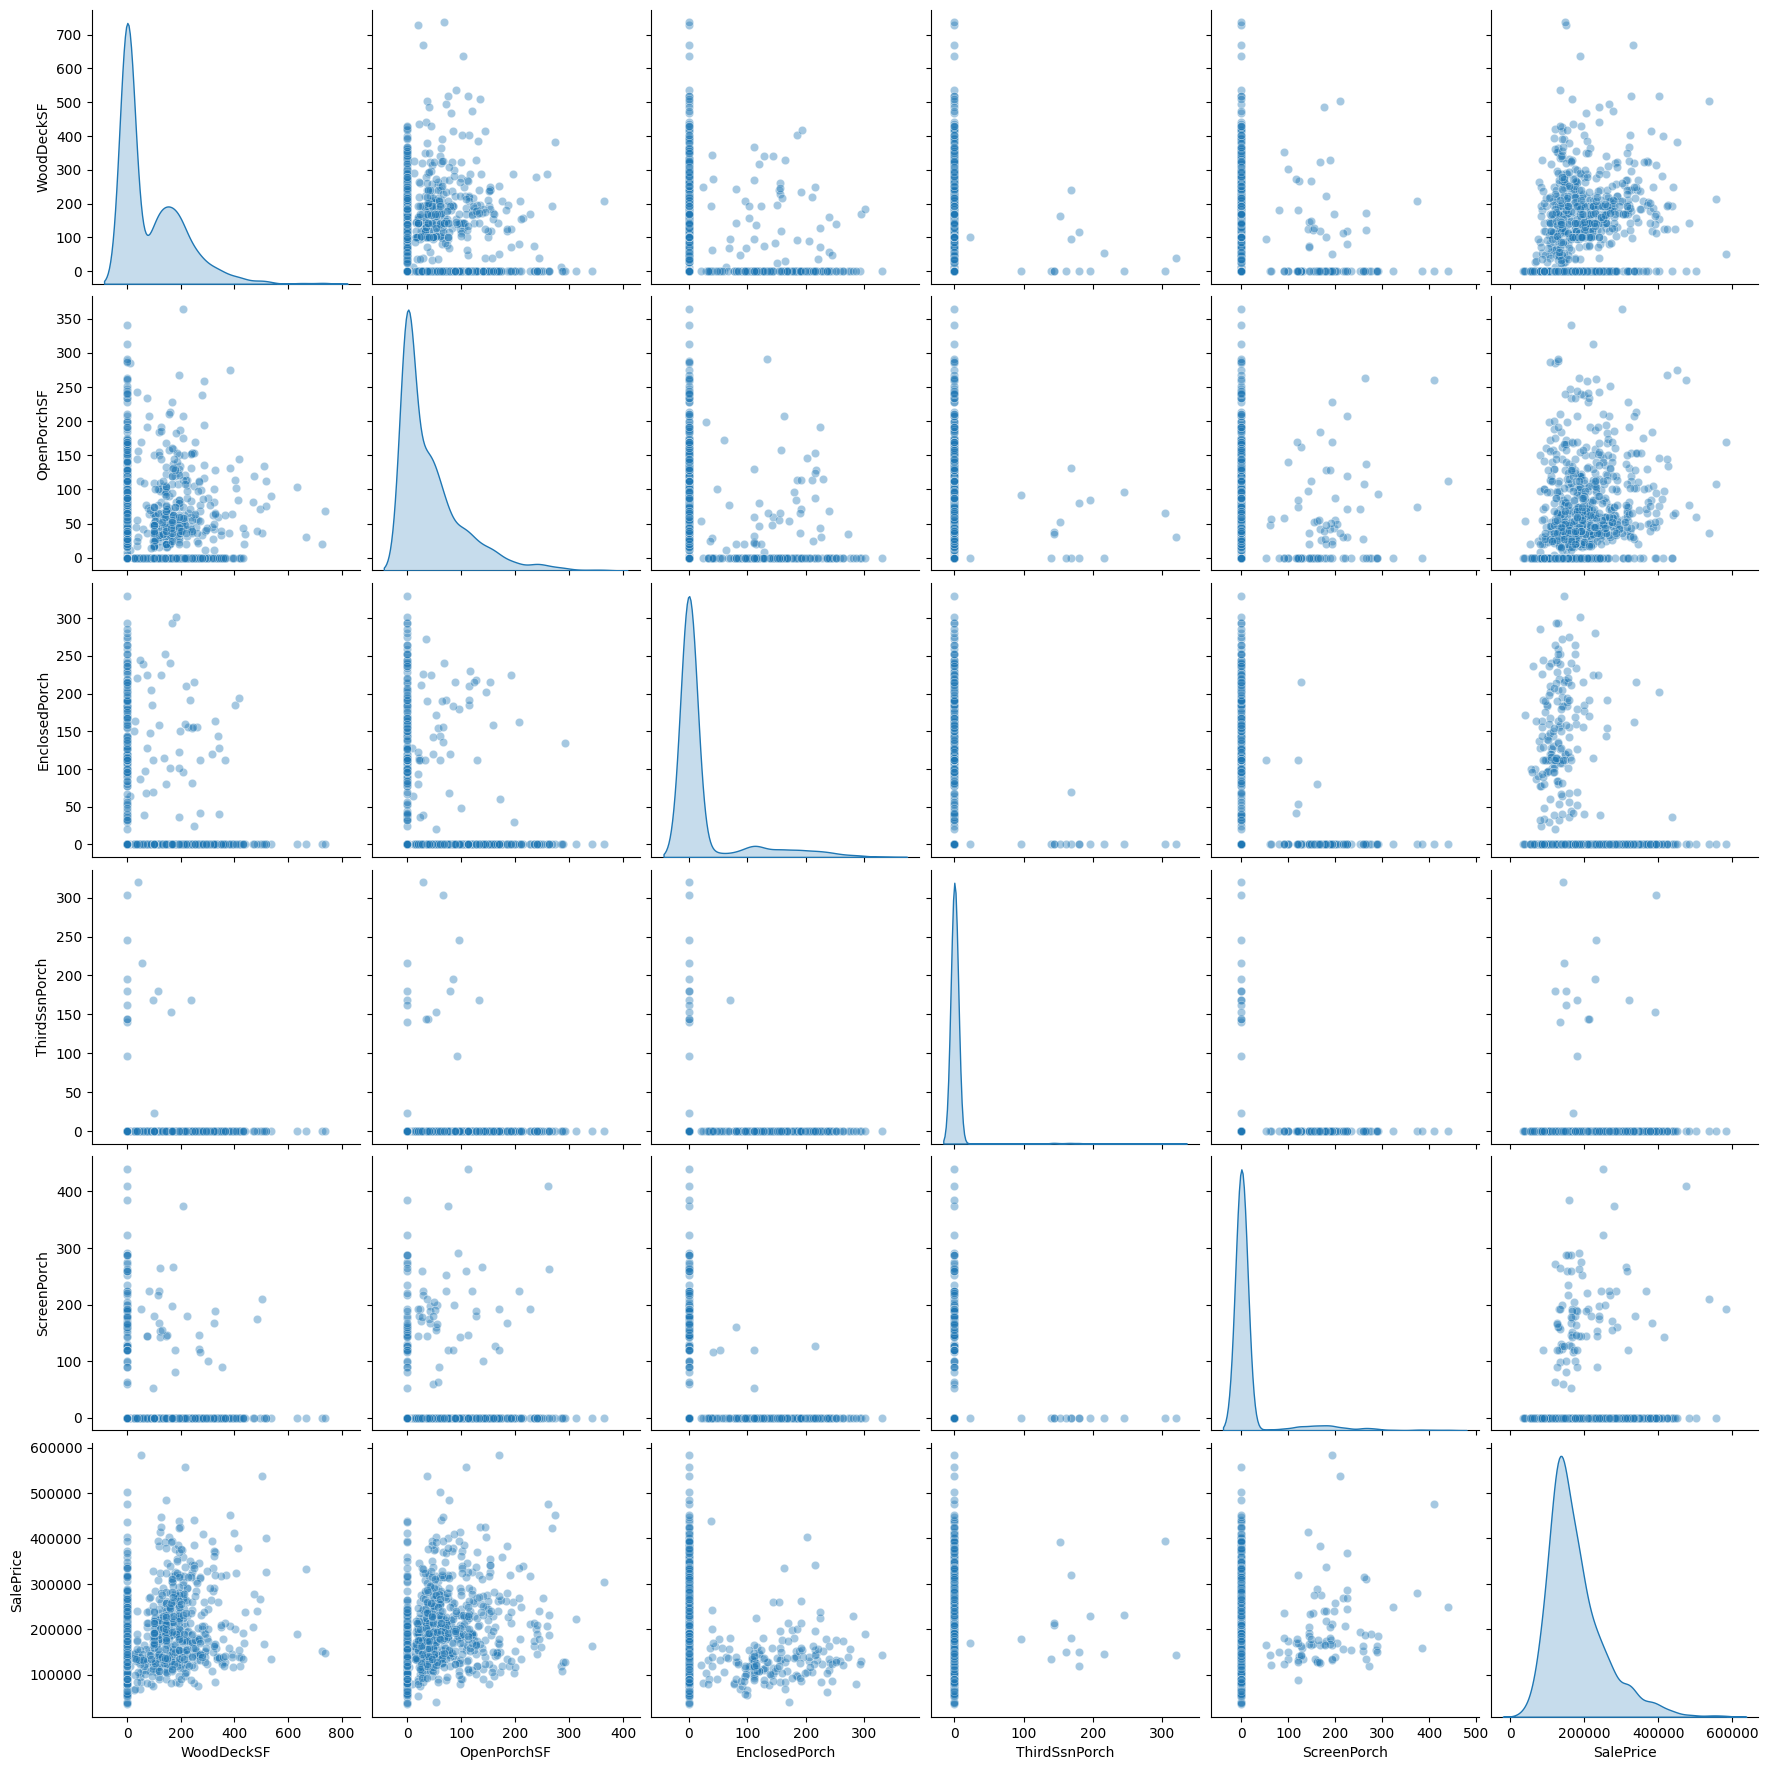

In [ ]:
sns.pairplot(
    trainN[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThirdSsnPorch', 'ScreenPorch', 'SalePrice']], 
    diag_kind='kde', 
    #hue='KitchenAbvGr',
    height=3, 
    plot_kws={'alpha': 0.4}
)

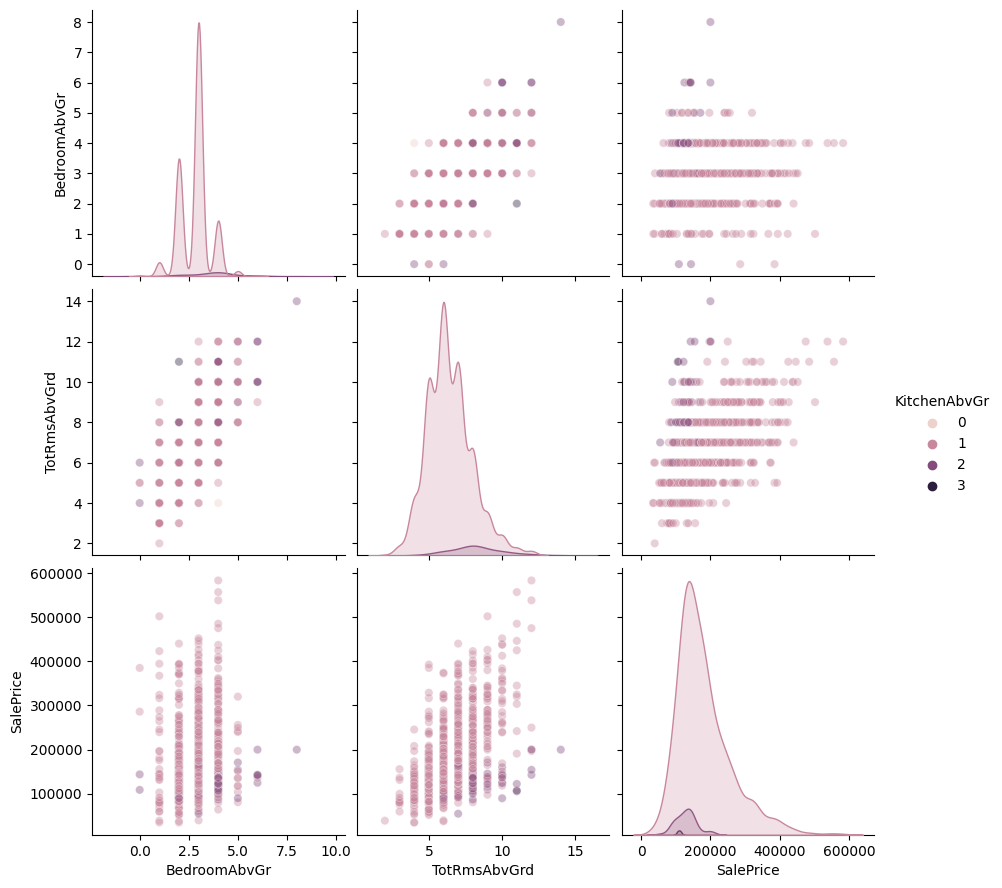

In [ ]:
sns.pairplot(
    trainN[['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'SalePrice']], 
    diag_kind='kde', 
    hue='KitchenAbvGr',
    height=3, 
    plot_kws={'alpha': 0.4}
)

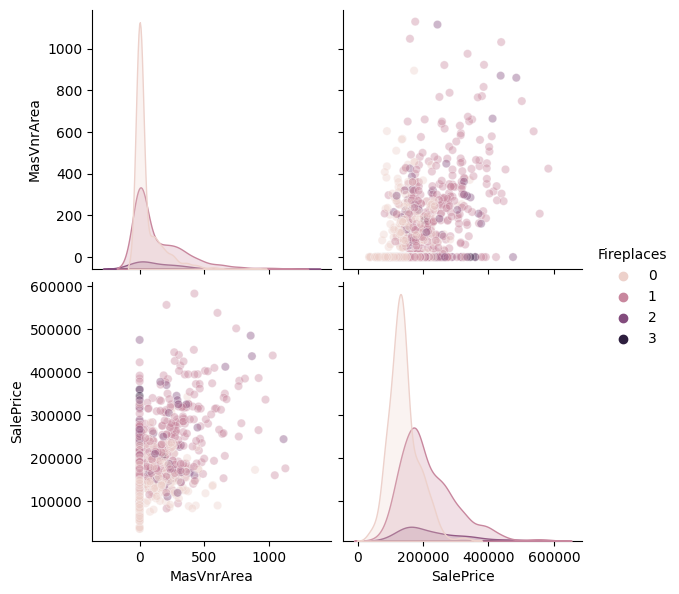

In [ ]:
sns.pairplot(
    trainN[['MasVnrArea', 'Fireplaces', 'SalePrice']], 
    diag_kind='kde', 
    hue='Fireplaces',
    height=3, 
    plot_kws={'alpha': 0.4}
)

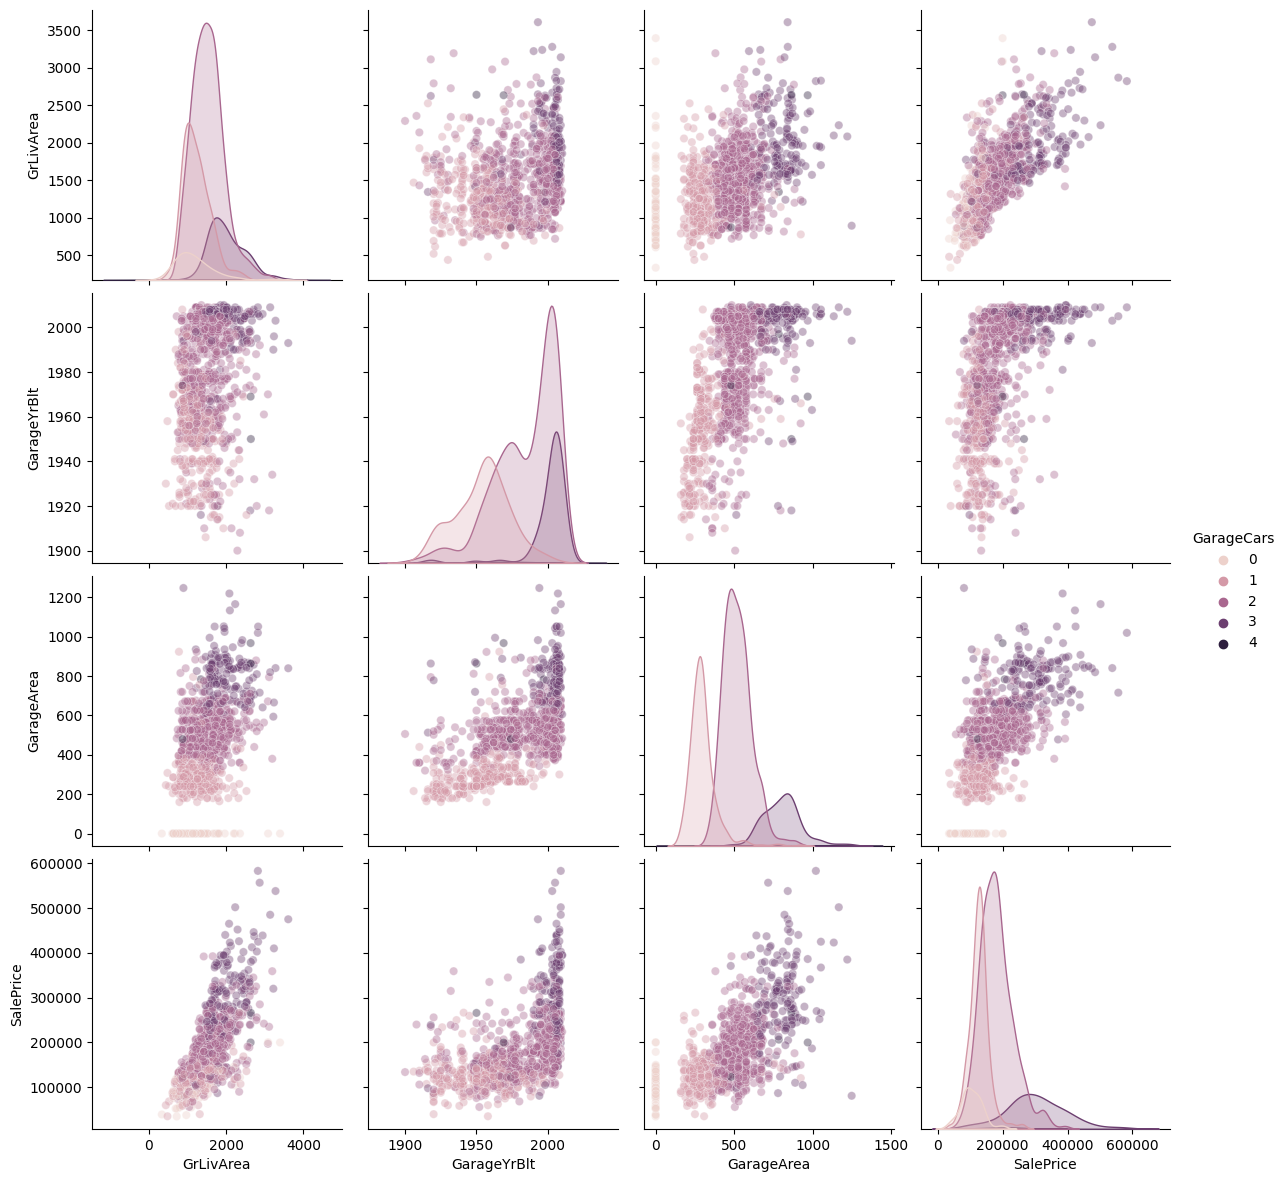

In [ ]:
sns.pairplot(
    trainN[['GrLivArea', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'SalePrice']], 
    diag_kind='kde', 
    hue='GarageCars', 
    height=3, 
    plot_kws={'alpha': 0.4}
)

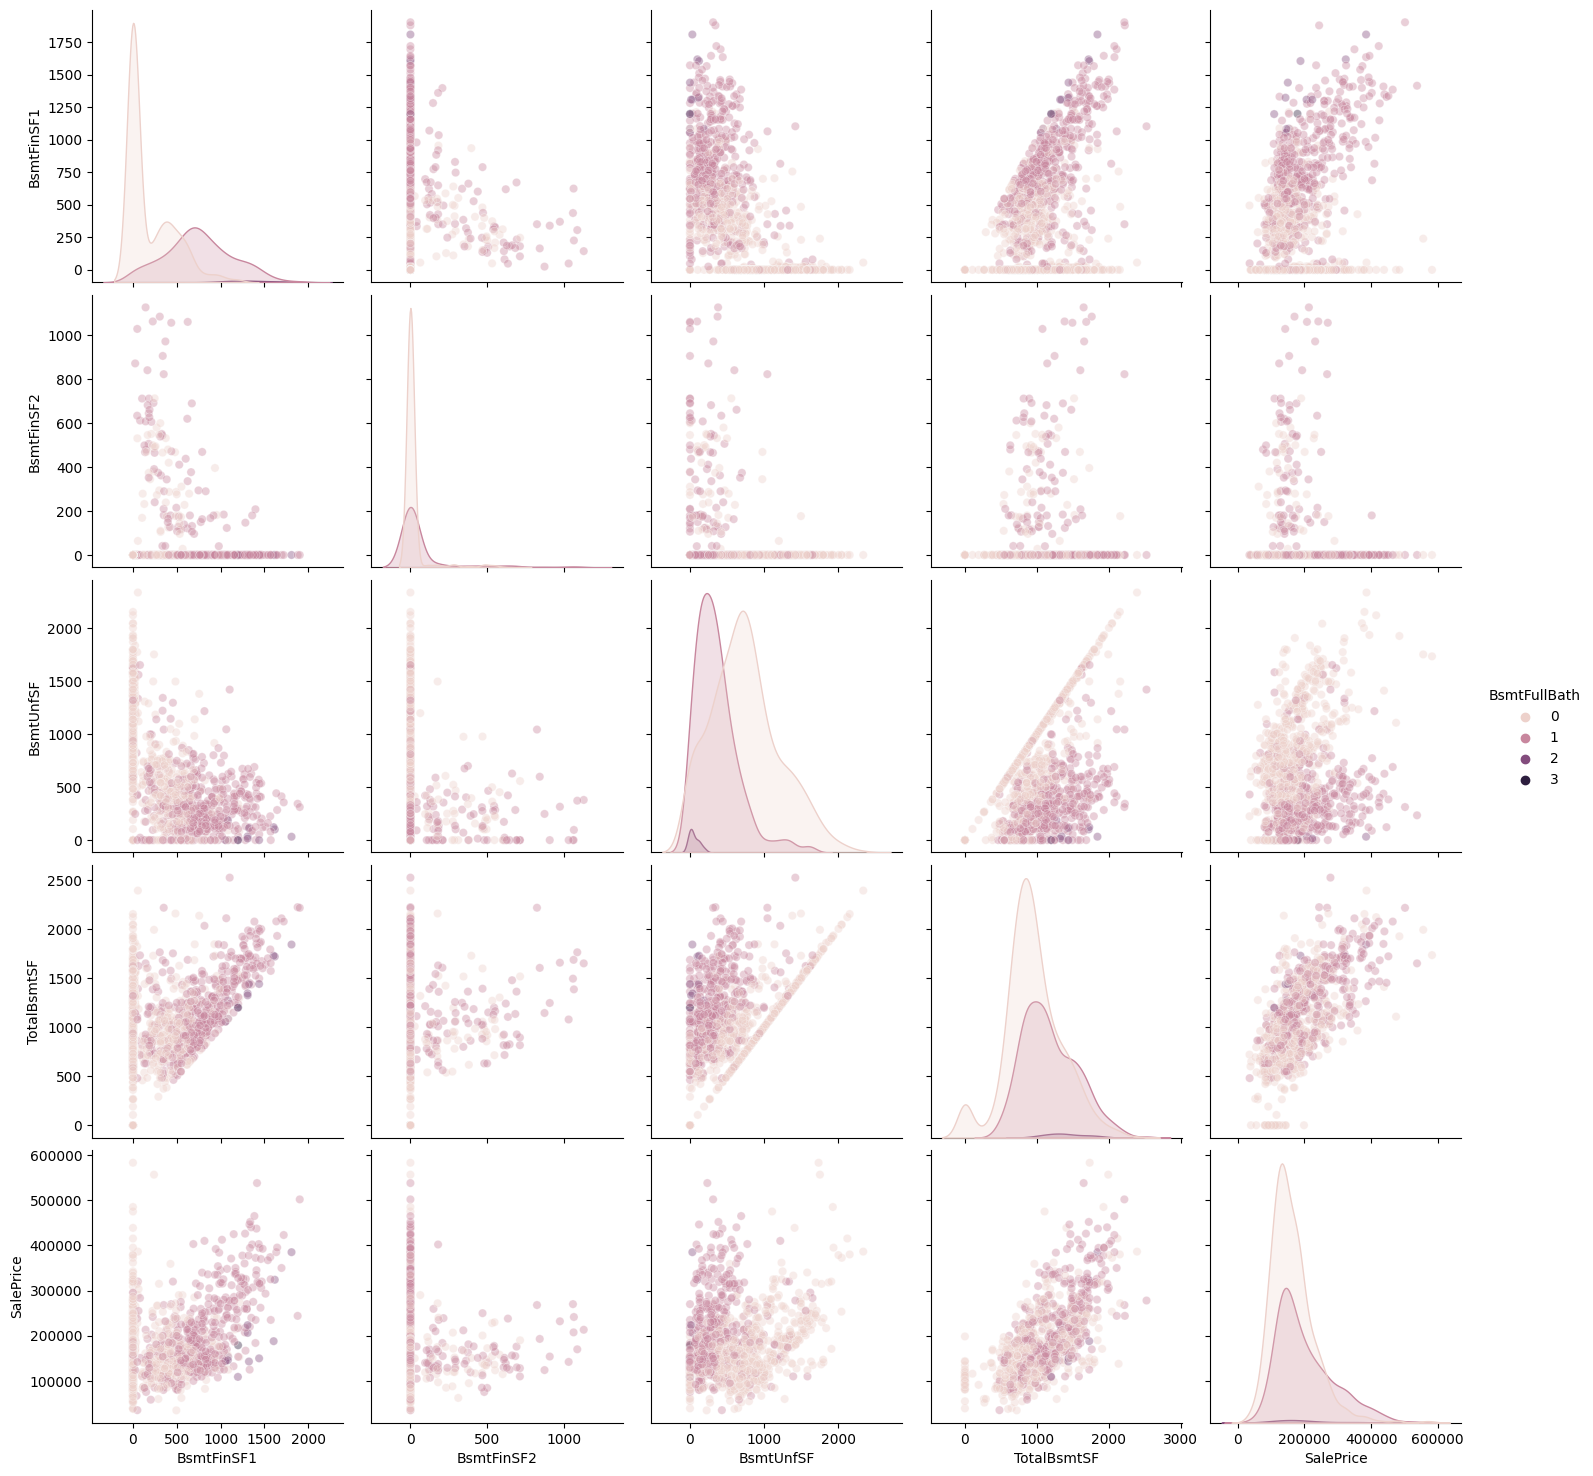

In [ ]:
sns.pairplot(
    trainN[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'TotalBsmtSF', 'SalePrice']], 
    diag_kind='kde', 
    hue='BsmtFullBath', 
    height=3, 
    plot_kws={'alpha': 0.4}
)

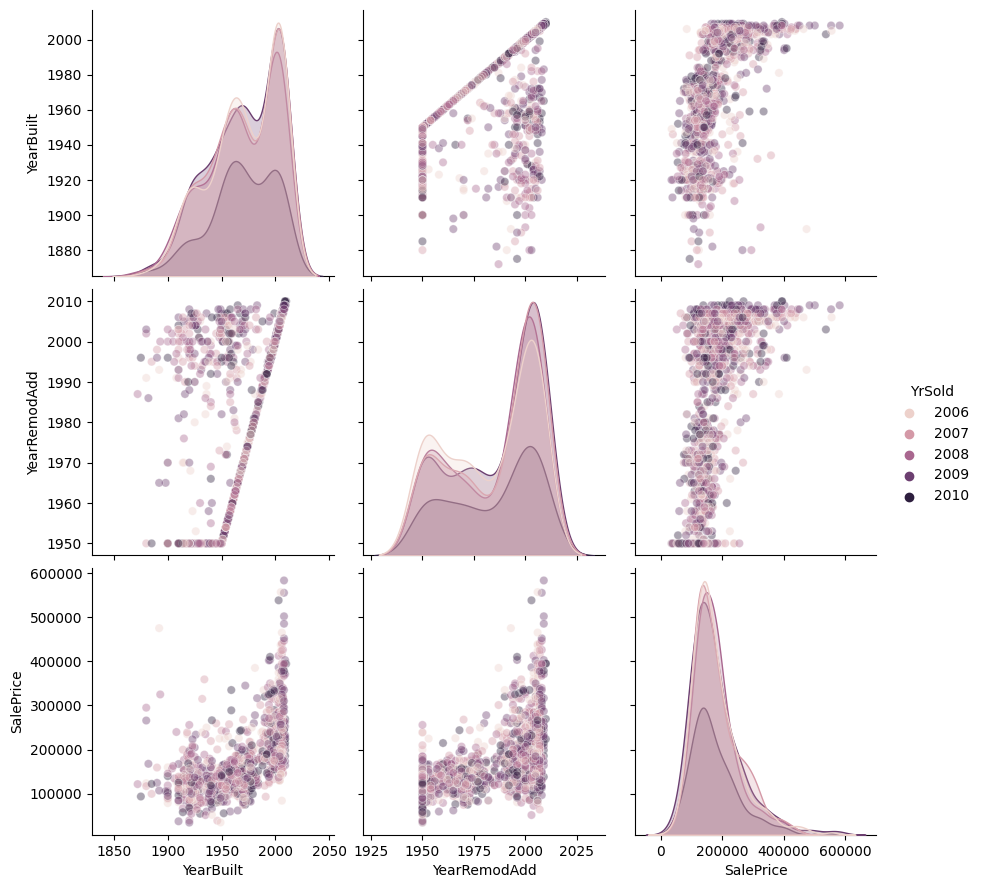

In [ ]:
sns.pairplot(
    trainN[['YearBuilt', 'YearRemodAdd', 'SalePrice', 'YrSold']], 
    diag_kind='kde', 
    hue='YrSold', 
    height=3, 
    plot_kws={'alpha': 0.4}
)

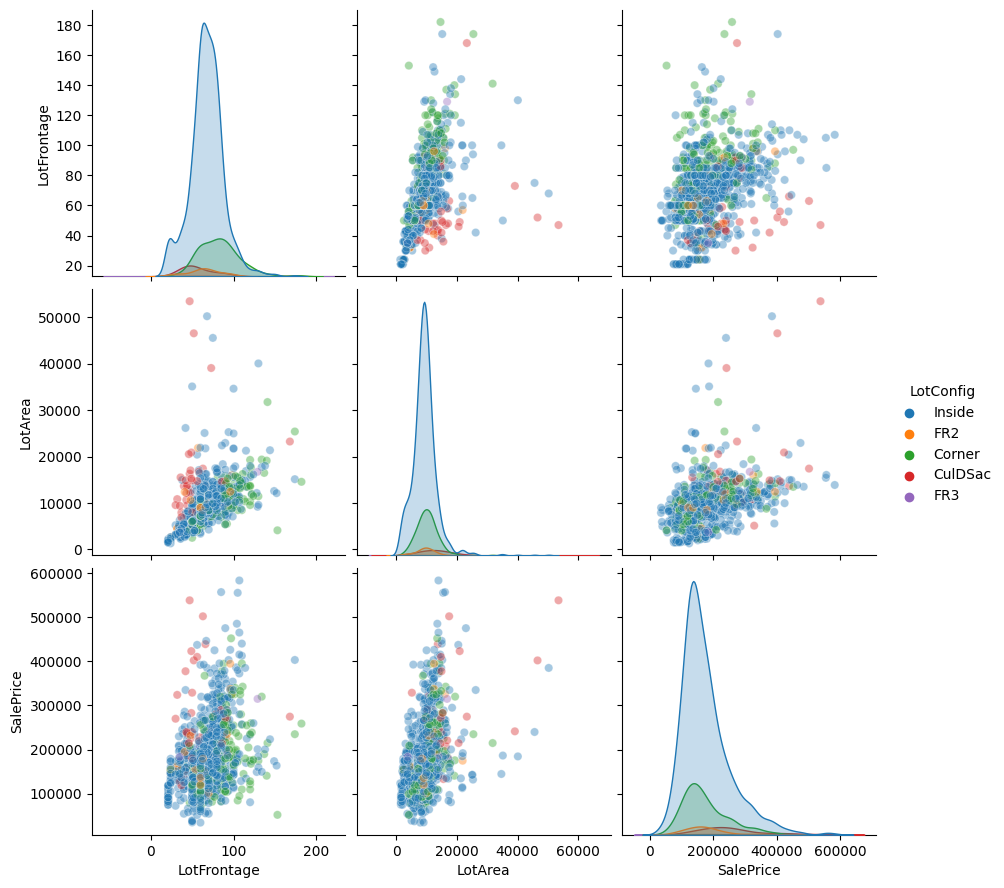

In [ ]:
sns.pairplot(
    trainN[['LotFrontage', 'LotConfig', 'LotArea', 'SalePrice']], 
    height=3, 
    hue='LotConfig', 
    plot_kws={'alpha': 0.4}
)

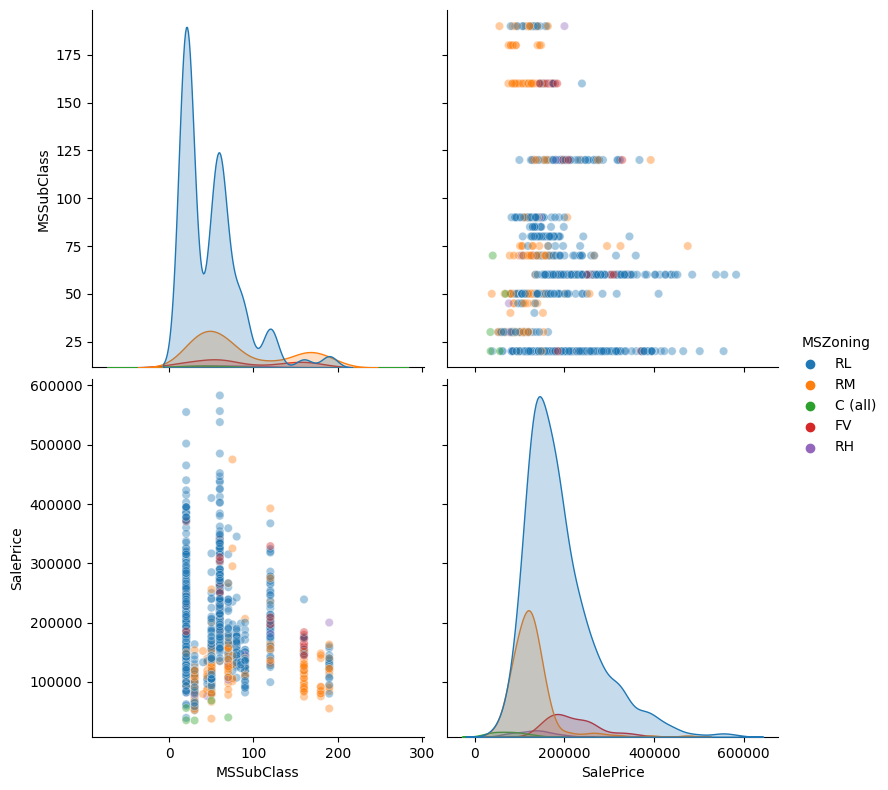

In [ ]:
sns.pairplot(
    trainN[['MSSubClass', 'MSZoning', 'SalePrice']], 
    hue='MSZoning', 
    height=4, 
    plot_kws={'alpha': 0.4}
)

## 2.2 Feature Selection:

### 2.2.1 Correlation analysis

In [62]:
def data_conversion(data: pd.DataFrame, test: bool = False) -> pd.DataFrame:
    if test:
        features = data
    else:
        features = data.drop(['SalePrice'], axis=1)
        targets = data['SalePrice']

    numCols = features.keys()[features.dtypes != 'O']
    features[numCols] = SimpleImputer(strategy='mean').fit_transform(features[numCols])
    features[numCols] = StandardScaler().fit_transform(features[numCols])

    catCols = features.keys()[features.dtypes == 'O']
    features[catCols] = SimpleImputer(strategy='most_frequent').fit_transform(features[catCols])
    for key in catCols:
        features[key] = LabelEncoder().fit_transform(features[key])

    return features if test else (features, targets)


def transformCorr(data: pd.DataFrame, threshold: float = 0.5) -> pd.Series:
    corr = data.stack().sort_values(ascending=False).drop_duplicates()
    correlation = corr[corr.values != 1]
    return correlation[abs(correlation) > threshold]

In [63]:
features, targets = data_conversion(trainN.copy())
testNew = data_conversion(test.copy(), test=True)


Features shape: (1171, 42)


<Axes: >

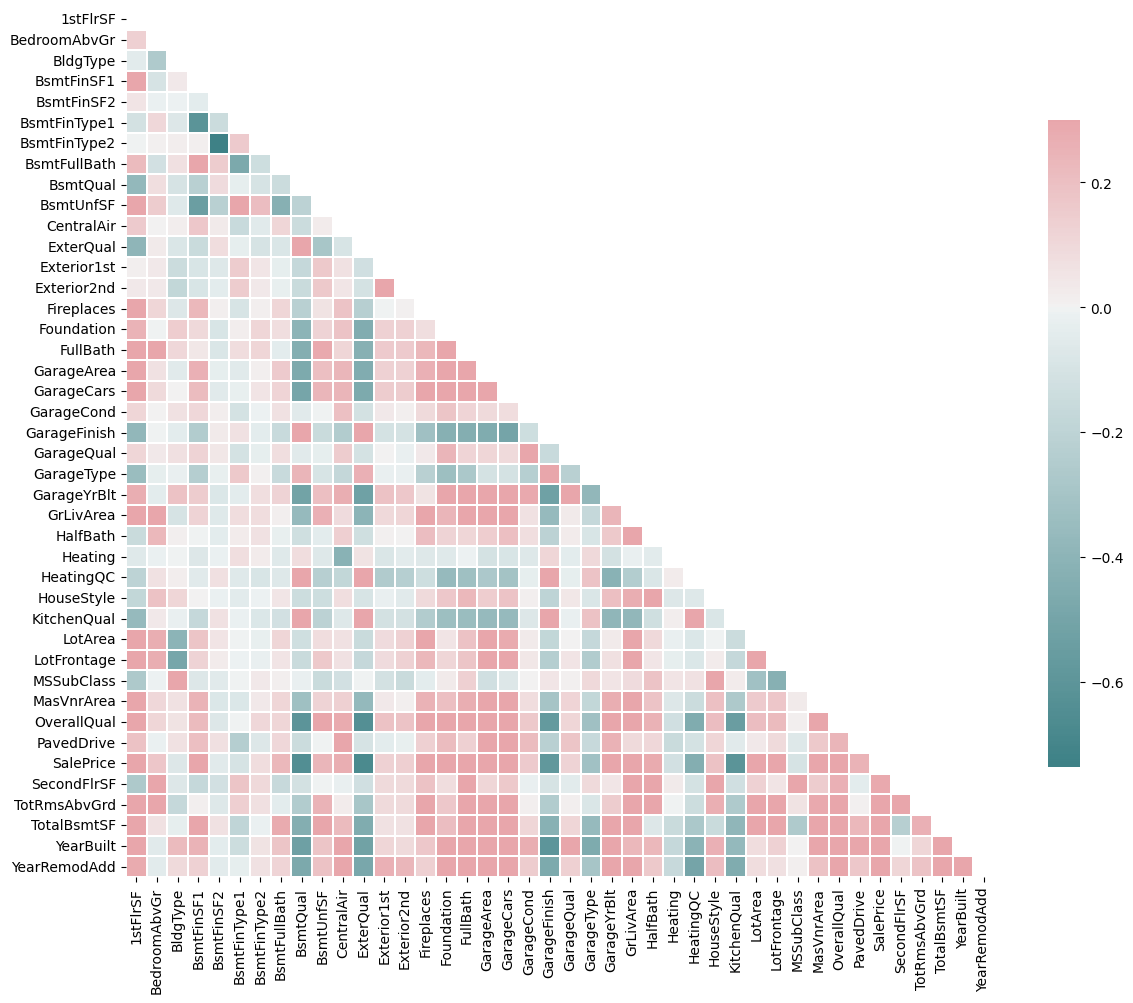

In [61]:
trainUpd = features.copy()
trainUpd['SalePrice'] = targets

correlation = transformCorr(trainUpd.corr(), 0.4)

level1 = correlation.keys().get_level_values(0).values
level2 = correlation.keys().get_level_values(1).values
columnsAdd = np.unique(np.hstack((level1, level2)))

newTrain = trainUpd[columnsAdd]

print('\nFeatures shape:', newTrain.shape)
corr = newTrain.corr()

plt.subplots(figsize=(14, 14))
sns.heatmap(
    corr, mask=np.triu(np.ones_like(corr, dtype=bool)), 
    cmap=sns.diverging_palette(200, 10, as_cmap=True), vmax=0.3, 
    center=0, square=True, linewidths=0.1, cbar_kws={"shrink": 0.6}
)

### 2.2.2 Selection of important features

In [50]:
importances = mutual_info_regression(features, targets, n_neighbors=10)

OverallQual    0.599512
dtype: float64


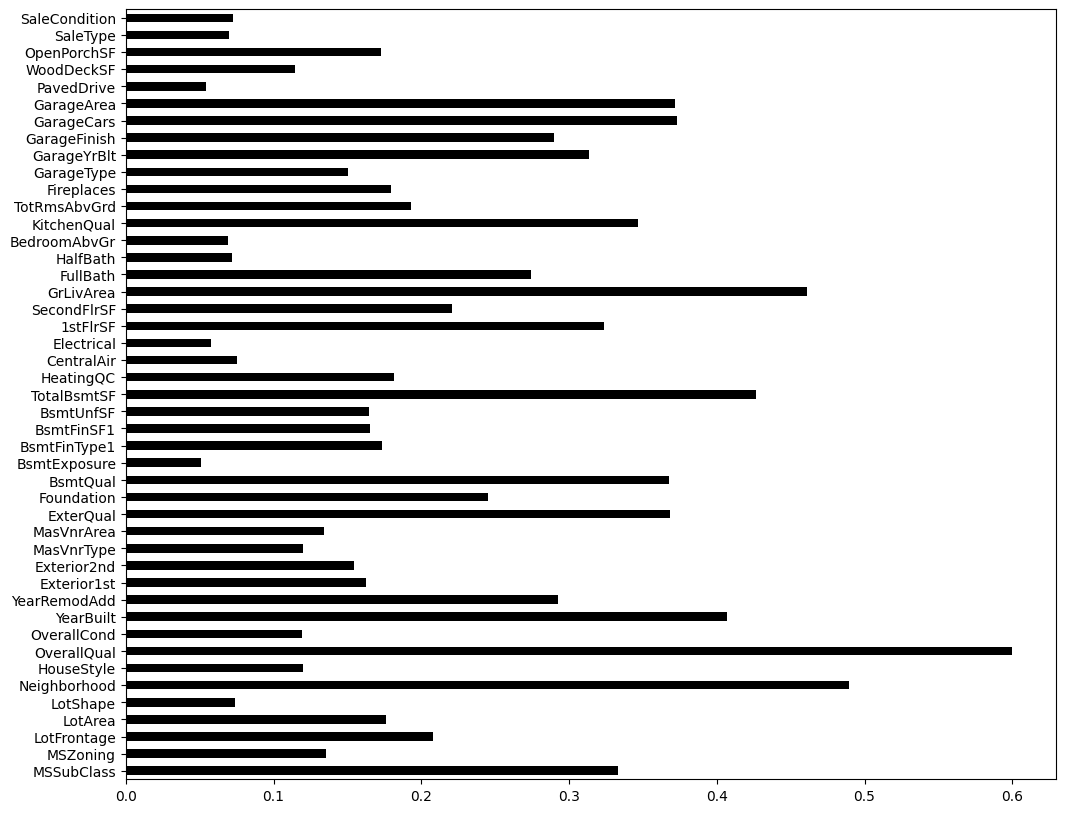

In [51]:
featureImportances = pd.Series(data=importances, index=features.keys())
print(featureImportances[featureImportances > 0.5])
plt.show(featureImportances[featureImportances > 0.05].plot(kind='barh', color='k', figsize=(12, 10)))

In [52]:
col_drop_FI = featureImportances[featureImportances < 0.1].keys()
col_drop_FI

Index(['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl',
       'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinSF2',
       'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch',
       'ThirdSsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [ ]:
test.keys()

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [53]:
featuresNew = features.drop(col_drop_FI, axis=1)

testNew.rename(columns={'2ndFlrSF': 'SecondFlrSF', '3SsnPorch': 'ThirdSsnPorch'}, inplace=True)
testNew.drop(col_drop_FI, axis=1, inplace=True)
testNew.drop(['Utilities', 'PoolArea'], axis=1, inplace=True)
testNew.drop(col_drop.keys(), axis=1, inplace=True)

## 3. Train:

In [58]:
xTrain, xValid, yTrain, yValid = train_test_split(
    newTrain.drop(['SalePrice'], axis=1), newTrain['SalePrice'], 
    #featuresNew, targets,
    test_size=0.1, random_state=10
)

model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500).fit(xTrain, yTrain)
print('\n[INFO] \non train: %.4f \non valid: %.4f' % 
      (model.score(xTrain, yTrain), model.score(xValid, yValid))
)


[INFO] 
on train: 0.9959 
on valid: 0.9246


In [ ]:
bagModel = BaggingRegressor(
    DecisionTreeRegressor(splitter='best', criterion='squared_error', max_depth=20), n_estimators=500, oob_score=True, bootstrap=True
).fit(xTrain, yTrain)
print('\n[INFO] \non train: %.4f \non valid: %.4f' % 
      (bagModel.score(xTrain, yTrain), bagModel.score(xValid, yValid))
)


[INFO] 
on train: 0.9861 
on valid: 0.9154


In [ ]:
sample_submission = pd.DataFrame(data=range(1461, 2920), columns=['Id'])
sample_submission['SalePrice'] = sgdModel.predict(testNew)
sample_submission.to_csv('sample_submission.csv', index=False)

In [ ]:
class OptGD:
    def objective(self, trial):
        params = {
            'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile']), 
            'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']), 
            'max_depth': trial.suggest_int('max_depth', 5, 25), 
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 2.0, log=True), 
            'n_estimators': trial.suggest_int('n_estimators', 100, 500), 
            'subsample': trial.suggest_float('subsample', 1e-4, 0.6, log=True)
        }
        if (params['loss'] == 'huber') or (params['loss'] == 'quantile'):
            params['alpha'] = trial.suggest_float('alpha', 1e-4, 1.0, log=True)

        gdModel = GradientBoostingRegressor(**params, n_iter_no_change=10).fit(self.X, self.Y)
        
        trainScore = gdModel.score(self.X, self.Y)
        validScore = gdModel.score(self.vd[0], self.vd[1])
        diff = abs(trainScore - validScore)
        
        return min(validScore, trainScore) if diff < 0.03 else -diff
        '''
        trainPred = xgbModel.predict(self.X)
        trainLossT = 1 / mean_squared_error(self.Y, trainPred, squared=False)

        validPred = xgbModel.predict(self.vd[0])
        validLossT = 1 / mean_squared_error(self.vd[1], validPred, squared=False)
        
        rel = validLossT / trainLossT
        return 2 / (validLossT + trainLossT) if (rel > 0.7 or rel < 1.3) else -validLossT
        '''
        
    
    def optimize(self, data: np.ndarray, label: np.ndarray, 
                 validation_data: tuple = None, n_trials: int = 10):
        self.X, self.Y = data, label
        self.vd = validation_data
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=n_trials, show_progress_bar=True)
        
        return study.best_trial.params

In [ ]:
objGD = OptGD()
optParamsGD = objGD.optimize(xTrain, yTrain, n_trials=300, validation_data=(xValid, yValid))
optParamsGD

/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/300 [00:00<?, ?it/s]

{'loss': 'absolute_error',
 'criterion': 'squared_error',
 'max_depth': 6,
 'learning_rate': 0.05408711663095883,
 'n_estimators': 307,
 'subsample': 0.32253072279324296}

In [ ]:
optGDModel = GradientBoostingRegressor(**optParamsGD).fit(xTrain, yTrain)

print('[SCORES] \non train: %s \non valid: %s' % 
      (optGDModel.score(xTrain, yTrain), 
       optGDModel.score(xValid, yValid))
      )

[SCORES] 
on train: 0.9754202058594856 
on valid: 0.9197981973193394


In [ ]:
sample_submission = pd.DataFrame(data=range(1461, 2920), columns=['Id'])
sample_submission['SalePrice'] = bagModel.predict(testNew)
sample_submission.to_csv('sample_submission.csv', index=False)

In [ ]:
class OptXGB:
    def __init__(self, reg: bool = False):
        self.reg = reg
    
    def objective(self, trial):
        params = {
            'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']), 
            'alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True), 
            'lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True), 
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 2.0, log=True), 
            'n_estimators': trial.suggest_int('n_estimators', 100, 500)
        }
        
        if (params['booster'] == 'gbtree') | (params['booster'] == 'dart'):
            params['max_depth'] = trial.suggest_int('max_depth', 5, 25)
            params['eta'] = trial.suggest_float('eta', 1e-4, 1.0, log=True)
            params['gamma'] = trial.suggest_float('gamma', 1e-4, 1.0, log=True)
            params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
            params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 10)
            params['subsample'] = trial.suggest_float('subsample', 1e-4, 1.0, log=True)
            params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 1e-4, 1.0, log=True)
        
        if params['booster'] == 'dart':
            params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
            params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
            params['rate_drop'] = trial.suggest_float('rate_drop', 1e-4, 1.0, log=True)
            params['skip_drop'] = trial.suggest_float('skip_drop', 1e-4, 1.0, log=True)
        
        
        params['objective'] = 'reg:squarederror'
        params['eval_metric'] = 'rmse'

        xgbModel = xgb.XGBRegressor(**params, early_stopping_rounds=5).fit(
            self.X, self.Y, 
            eval_set=[(self.X, self.Y), (self.vd[0], self.vd[1])], 
            verbose=False
        )
        
        trainScore = xgbModel.score(self.X, self.Y)
        validScore = xgbModel.score(self.vd[0], self.vd[1])
        diff = abs(trainScore - validScore)
        
        return min(trainScore, validScore) if diff < 0.03 else -diff
        '''
        trainPred = xgbModel.predict(self.X)
        trainLossT = 1 / mean_squared_error(self.Y, trainPred, squared=False)

        validPred = xgbModel.predict(self.vd[0])
        validLossT = 1 / mean_squared_error(self.vd[1], validPred, squared=False)
        
        rel = validLossT / trainLossT
        return 2 / (validLossT + trainLossT) if (rel > 0.7 or rel < 1.3) else -validLossT
        '''
        
    
    def optimize(self, data: np.ndarray, label: np.ndarray, 
                 validation_data: tuple = None, n_trials: int = 10):
        self.X, self.Y = data, label
        self.vd = validation_data
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=n_trials, show_progress_bar=True)
        
        return study.best_trial.params

In [ ]:
objXGB = OptXGB(reg=True)
optParams = objXGB.optimize(xTrain, yTrain, n_trials=100, validation_data=(xValid, yValid))
optParams

/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

{'booster': 'gblinear',
 'reg_alpha': 0.11537191120058951,
 'reg_lambda': 0.011182218554872227,
 'learning_rate': 0.39842584616807486,
 'n_estimators': 479}

In [ ]:
optModel = xgb.XGBRegressor(**optParams).fit(xTrain, yTrain)

print('[SCORES] \non train: %s \non valid: %s' % 
      (optModel.score(xTrain, yTrain), 
       optModel.score(xValid, yValid))
      )

[SCORES] 
on train: 0.8984929760164124 
on valid: 0.8913274017776895


In [ ]:
{'booster': 'gblinear',
 'reg_alpha': 0.019128899800304397,
 'reg_lambda': 0.00581672833480405,
 'learning_rate': 0.5493546514277411,
 'n_estimators': 176}

 91.1, 90.8